In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Input

from bayes_opt import BayesianOptimization

In [5]:
# Load the dataset
df = pd.read_csv("Quote-Equity-EICHERMOT-EQ-08-10-2023-to-08-10-2024.csv", skipinitialspace=True)
df.columns = df.columns.str.strip()

# Preprocess the data
df["Date"] = pd.to_datetime(df['Date'])
df["Date"].dt.strftime('%Y/%m/%d')
df.index = df['Date']
df['close'] = df['close'].astype(str).str.replace(',', '', regex=False).astype(float)

# Prepare the data
dataset = df['close'].values.reshape(-1, 1) 

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Split into training and testing sets
train_data, test_data = train_test_split(scaled_data, test_size=0.3, shuffle=False)

In [9]:
# Create the dataset with lookback period
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    if len(dataset) <= look_back + 1:
        return np.array(X), np.array(Y)
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 40  # Adjust if needed
X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape Y_train before Bayesian Optimization
Y_train = Y_train.reshape(-1, 1)

In [13]:
# Function to optimize with Bayesian Optimization
def lstm_optimization(units1, units2, batch_size):
    units1 = int(units1)
    units2 = int(units2)
    batch_size = int(batch_size)

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=units1, return_sequences=True))
    model.add(LSTM(units=units2))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, Y_train, epochs=100, batch_size=batch_size,
                        verbose=0, validation_split=0.1, callbacks=[early_stopping])

    # Evaluate the model on the test data
    test_predict = model.predict(X_test)
    test_predict = test_predict.reshape(-1, 1)  # Reshape to 2D
    test_predict = scaler.inverse_transform(test_predict)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape Y_test
    rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))

    return -rmse  # Return negative RMSE

In [15]:
# Define the parameter bounds
pbounds = {
    'units1': (20, 100),
    'units2': (20, 100),
    'batch_size': (16, 64)
}

# Create a BayesianOptimization object
optimizer = BayesianOptimization(
    f=lstm_optimization,
    pbounds=pbounds,
    random_state=1,
)

# Perform Bayesian Optimization
optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | batch_... |  units1   |  units2   |
-------------------------------------------------------------
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
| 1         | -235.6    | 36.02     | 77.63     | 20.01     |
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
| 2         | -277.5    | 30.51     | 31.74     | 27.39     |
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020C3751A700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retraci

In [16]:
# Get the best hyperparameters
best_params = optimizer.max['params']

# Train the final model with the best hyperparameters
best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], 1)))
best_model.add(LSTM(units=int(best_params['units1']), return_sequences=True))
best_model.add(LSTM(units=int(best_params['units2'])))
best_model.add(Dense(1))

best_model.compile(loss='mean_squared_error', optimizer='adam')
best_model.fit(X_train, Y_train, epochs=100, batch_size=int(best_params['batch_size']), verbose=2, validation_split=0.1)

Epoch 1/100
5/5 - 21s - 4s/step - loss: 0.2991 - val_loss: 0.0021
Epoch 2/100
5/5 - 1s - 121ms/step - loss: 0.0435 - val_loss: 0.0501
Epoch 3/100
5/5 - 1s - 149ms/step - loss: 0.0305 - val_loss: 0.0068
Epoch 4/100
5/5 - 1s - 128ms/step - loss: 0.0201 - val_loss: 0.0022
Epoch 5/100
5/5 - 1s - 138ms/step - loss: 0.0243 - val_loss: 0.0047
Epoch 6/100
5/5 - 1s - 141ms/step - loss: 0.0140 - val_loss: 0.0143
Epoch 7/100
5/5 - 1s - 147ms/step - loss: 0.0153 - val_loss: 0.0166
Epoch 8/100
5/5 - 1s - 126ms/step - loss: 0.0128 - val_loss: 0.0080
Epoch 9/100
5/5 - 1s - 132ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 10/100
5/5 - 1s - 132ms/step - loss: 0.0114 - val_loss: 0.0047
Epoch 11/100
5/5 - 0s - 67ms/step - loss: 0.0096 - val_loss: 0.0069
Epoch 12/100
5/5 - 0s - 85ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 13/100
5/5 - 1s - 146ms/step - loss: 0.0087 - val_loss: 0.0026
Epoch 14/100
5/5 - 1s - 133ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 15/100
5/5 - 1s - 107ms/step - loss: 0.00

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
Train RMSE: 106.18 RMSE
Test RMSE: 163.80 RMSE


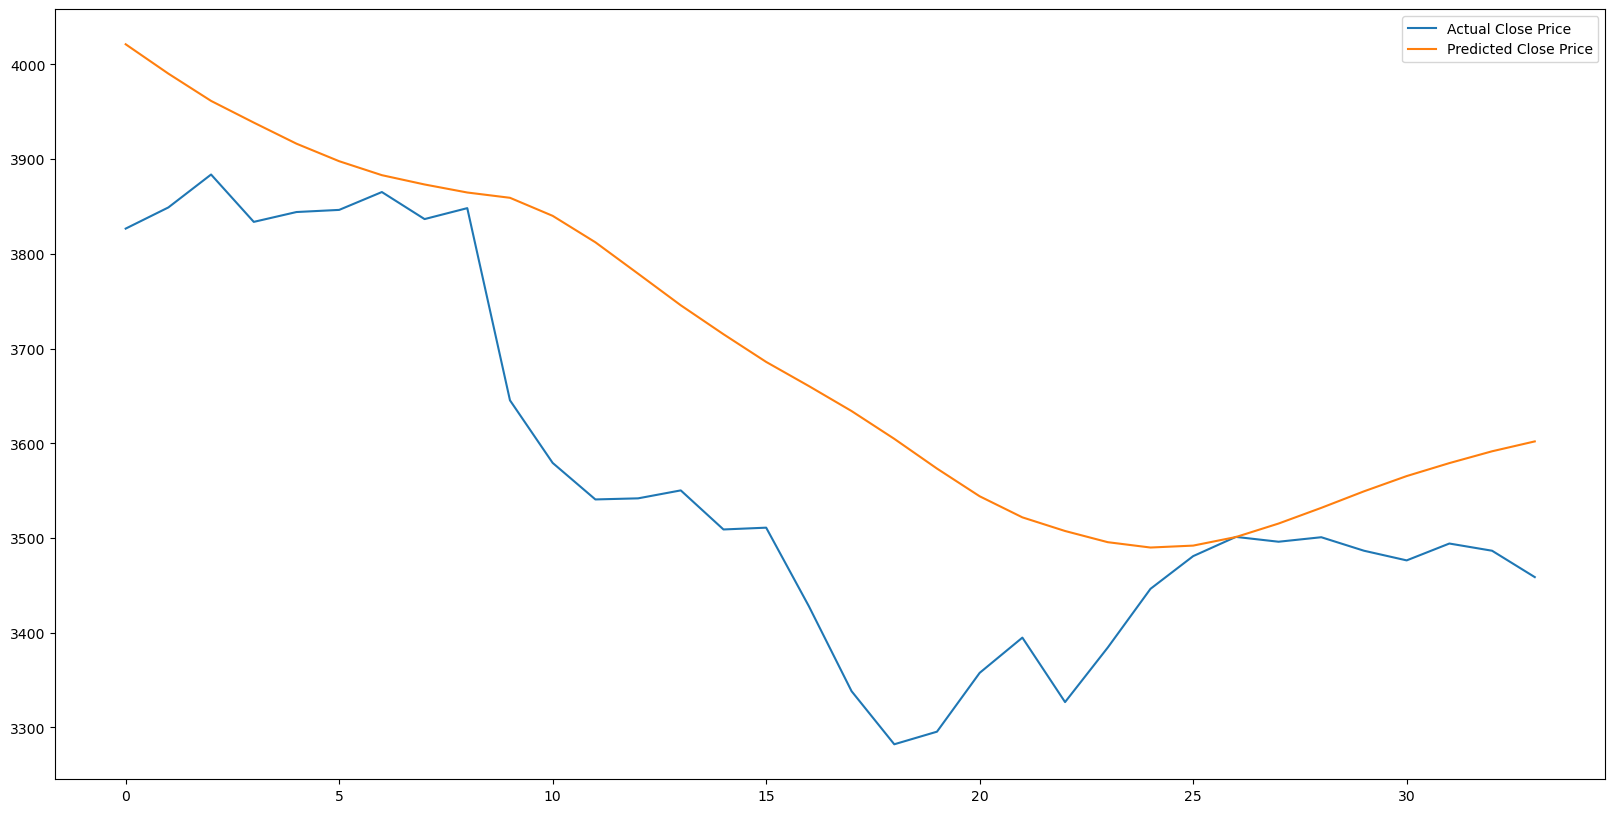

In [17]:
# Make predictions
train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform(Y_train)
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_predict))
print('Train RMSE: %.2f RMSE' % (train_rmse))
print('Test RMSE: %.2f RMSE' % (test_rmse))

# Plot the results
plt.plot(Y_test_inv.flatten(), label='Actual Close Price')
plt.plot(test_predict.flatten(), label='Predicted Close Price')
plt.legend()
plt.show()

In [29]:
best_model.save("stock_prediction_model_RE.keras")